# Panan01 Along Slope Anomaly

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from pathlib import Path
import xgcm

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34431,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40435,Total threads: 1
Dashboard: /proxy/46441/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38491,


In [3]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month_z.nc'))

In [4]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo', 'vo','volcello']].sel(yh = slice(-80, -59),yq = slice(-80, -59), z_l = slice(None, 500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [5]:
# Time mean (last 5 yrs)
uC = cont['uo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
vC = cont['vo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
uMW = melt['uo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
vMW = melt['vo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')

In [6]:
cont_n = xr.merge([uC,vC])
cont_n= cont_n.isel(xq = slice(1, None), yq = slice(1, None))
pert_n = xr.merge([uMW,vMW])
pert_n= pert_n.isel(xq = slice(1, None), yq = slice(1, None))

In [7]:
path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

ocean_static_C = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [8]:
grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                             'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [9]:
path_to_ocean_static_MW = Path('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/output021/20010301.ocean_static.nc')
ocean_static_MW = xr.open_dataset(path_to_ocean_static_MW)

ocean_static_MW = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [10]:
grid_MW = xgcm.Grid(ocean_static_MW, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                               'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [11]:
dh_dx_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'X') / ocean_static_C['dxCu'], 'Y')
dh_dy_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'Y') / ocean_static_C['dyCv'], 'X')

In [12]:
dh_dx_C

<xarray.DataArray (yq: 483, xq: 3600)> Size: 7MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00175529,  0.00936127,  0.00574664, ..., -0.01809645,
         0.0040684 ,  0.0021677 ],
       [ 0.00767963,  0.0143665 ,  0.00770131, ..., -0.01519741,
         0.00470569, -0.00035324],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01

In [13]:
dh_dx_MW = grid_MW.interp(grid_MW.diff(ocean_static_MW['deptho'], 'X') / ocean_static_MW['dxCu'], 'Y')
dh_dy_MW = grid_MW.interp(grid_MW.diff(ocean_static_MW['deptho'], 'Y') / ocean_static_MW['dyCv'], 'X')

In [14]:
dh_dx_MW

<xarray.DataArray (yq: 483, xq: 3600)> Size: 7MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00175529,  0.00936127,  0.00574664, ..., -0.01809645,
         0.0040684 ,  0.0021677 ],
       [ 0.00767963,  0.0143665 ,  0.00770131, ..., -0.01519741,
         0.00470569, -0.00035324],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yq       (yq) float64 4kB -79.95 -79.9 -79.86 ... -59.11 -59.06 -59.01

In [15]:
uC_int = grid_C.interp(cont_n['uo'], 'Y')
vC_int = grid_C.interp(cont_n['vo'], 'X')

In [20]:
uMW_int = grid_MW.interp(pert_n['uo'], 'Y')
vMW_int = grid_MW.interp(pert_n['vo'], 'X')

In [23]:
slope_C = np.sqrt(dh_dy_C**2 + dh_dx_C**2)
testC = uC_int*dh_dy_C - vC_int*dh_dx_C

In [24]:
slope_MW = np.sqrt(dh_dy_MW**2 + dh_dx_MW**2)
testMW = uMW_int*dh_dy_MW - vMW_int*dh_dx_MW

In [25]:
alongslope_velocity_C = testC/slope_C
alongslope_velocity_MW = testMW/slope_MW

In [26]:
alongslope_velocity_C = alongslope_velocity_C.astype('float32')
alongslope_velocity_MW = alongslope_velocity_MW.astype('float32')

In [27]:
alongslope_velocity_C = alongslope_velocity_C.load()

In [28]:
alongslope_velocity_MW = alongslope_velocity_MW.load()

In [30]:
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'Y')
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'X')
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yh: 483, xh: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.09975617, -0.09094817, -0.06377907, ..., -0.0095992 ,
         -0.02756915, -0.08241944],
        [-0.09716783, -0.10612859, -0.10581061, ..., -0.00626347,
         -0.05979631, -0.09793527],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.03503174, -0.03061477, -0.02462857, ...,  0.00457276,
         -0.0038525 , -0.02764175],
        [-0.03232463, -0.03808923, -0.03943953, ...,  0.00427113,
         -0.01686579, -0.03205758],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.03327004, -0.02915143, -0.02338151, ...,  0.0040082 ,
         -0.00393874, -0.02628681],
        [-0.03081564, -0.03622977, -0.03748878, ...,  0.00360225,
         -0.01627307, -0.03054059],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
Dimensions without coordinates: z_l

In [32]:
alongslope_velocity_MW = grid_MW.interp(alongslope_velocity_MW, 'Y')
alongslope_velocity_MW = grid_MW.interp(alongslope_velocity_MW, 'X')
alongslope_velocity_MW

<xarray.DataArray (z_l: 39, yh: 483, xh: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.08322652, -0.07897942, -0.06158182, ..., -0.00275164,
         -0.01725148, -0.06418265],
        [-0.07854001, -0.09289798, -0.099494  , ..., -0.00222736,
         -0.04272151, -0.07405977],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.02358637, -0.02164296, -0.02155765, ...,  0.00736156,
          0.0013464 , -0.01633292],
        [-0.02103488, -0.02874285, -0.03345881, ...,  0.00538765,
         -0.00788485, -0.01847452],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02244196, -0.02065208, -0.02047614, ...,  0.00661832,
          0.00096421, -0.01559943],
        [-0.02015001, -0.02739893, -0.03183681, ...,  0.00461472,
         -0.00781121, -0.01772168],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
Dimensions without coordinates: z_l

In [33]:
depth = xr.open_dataset(path_to_ocean_static_C)['deptho']
area = xr.open_dataset(path_to_ocean_static_C)['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_month_z.nc')['so'].isel(time=0,z_l=0)
volcello = cont['volcello'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')

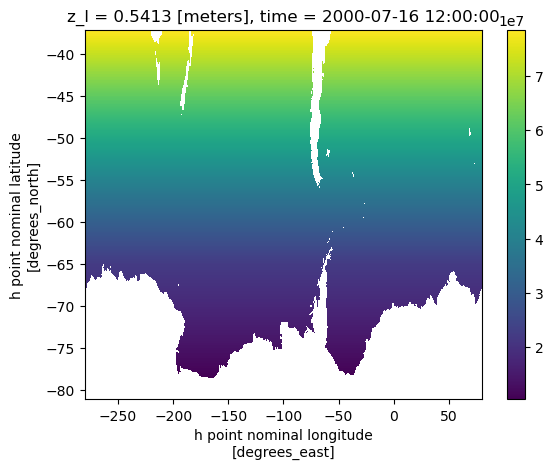

In [34]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [35]:
thickness = volcello / area_corr
thickness = thickness.sel(yh=slice(-80, -59)).sel(z_l=slice(None, 500))

In [36]:
thickness

<xarray.DataArray (z_l: 39, yh: 483, xh: 3600)> Size: 271MB
dask.array<truediv, shape=(39, 483, 3600), dtype=float32, chunksize=(22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
  * z_l      (z_l) float64 312B 0.5413 1.681 2.94 4.332 ... 383.0 423.7 468.4
    time     object 8B 2000-07-16 12:00:00

In [37]:
# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity_C = (alongslope_velocity_C * thickness).sum('z_l') / thickness.sum('z_l')
barotropic_alongslope_velocity_MW = (alongslope_velocity_MW * thickness).sum('z_l') / thickness.sum('z_l')

In [38]:
barotropic_alongslope_velocity_C = barotropic_alongslope_velocity_C.load()

In [39]:
barotropic_alongslope_velocity_MW = barotropic_alongslope_velocity_MW.load()

In [42]:
barotropic_alongslope_velocity_MW

<xarray.DataArray (yh: 483, xh: 3600)> Size: 7MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.029997  , -0.02703704, -0.02827902, ...,  0.01288537,
         0.00469496, -0.02012845],
       [-0.02549257, -0.03653046, -0.04334915, ...,  0.01119416,
        -0.00728738, -0.0220764 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
    time     object 8B 2000-07-16 12:00:00

In [43]:
barotropic_alongslope_velocity_anom = barotropic_alongslope_velocity_MW - barotropic_alongslope_velocity_C

In [44]:
barotropic_alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_cont_prescribed_pan01.nc')
barotropic_alongslope_velocity_MW.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_melt_prescribed_pan01.nc')
barotropic_alongslope_velocity_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_anom_prescribed_pan01.nc')

# Plotting

In [45]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.275
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [46]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [47]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [52]:
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

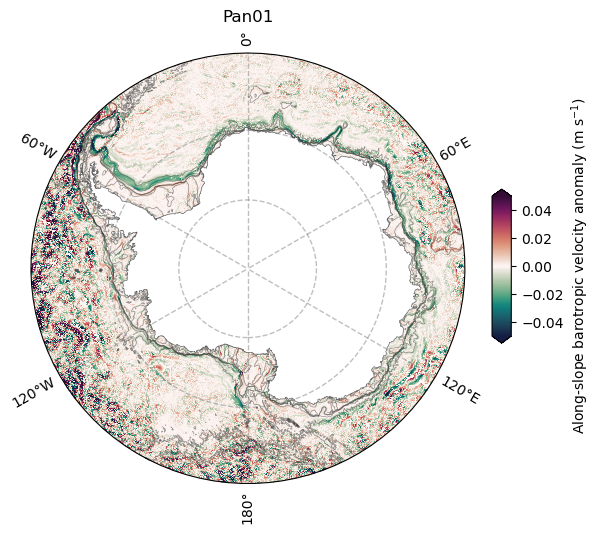

In [54]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity_anom.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.05, vmax=0.05,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': 'Along-slope barotropic velocity anomaly (m s$^{-1}$)',
                                                      'aspect': 8})
  
ax.set_title('Pan01');

In [55]:
ocean_static_MW['dxCu']

<xarray.DataArray 'dxCu' (yh: 483, xq: 3600)> Size: 7MB
[1738800 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
  * xq       (xq) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
Attributes:
    units:          m
    long_name:      Delta(x) at u points (meter)
    cell_methods:   time: point
    interp_method:  none